# STABLE DIFFUSION
### `DL Course, Dr. Soleymani`
#### Homework 5
*`Full Name:`* Reza Vahidimajd

*`SID:`* 99102491


## What is Stable Diffusion


Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) and [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). for more information.



General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). This scheduler is able to achieve great quality in less steps. You can try with 25 instead of the default 50!

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

## Setup & Imports

In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul  1 17:22:21 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 30%   30C    P2   130W / 350W |    743MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qqU --upgrade transformers==4.40.0 diffusers==0.27.2 ftfy==6.2.0 accelerate datasets bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.6 MB/s eta 0:00:00
ERROR: pip's dependency

In [13]:
from argparse import Namespace
import math
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import autocast
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, DDPMScheduler
from accelerate import Accelerator
from accelerate.utils import set_seed
import bitsandbytes as bnb

In [15]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# PART 1 (30 pts)




Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [16]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")                     # Load the autoencoder model which will be used to decode the latents into image space.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")            # The UNet model for generating the latents
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [17]:
def pil_to_latent(input_im):

    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(transforms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):

    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

### Classifier Free Guidance

By default, the model doesn't often do what we ask. If we want it to follow the prompt better, we use a hack called CFG.

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`


In [18]:
def prompt_to_emb(prompt):


  '''
      # TODO: This function should take in a prompt (list of strings) and return concatenated unconditional text embedding and text embeddings (torch tensor) (10 pts)
        1. Tokenize the prompt using the tokenizer, ensuring it fits the model's maximum length. This includes padding, truncation, and conversion to PyTorch tensors.
        2. Generate unconditional input for the model.
        3. Compute the text embedding for the provided prompt and for the unconditional input. (Disable gradients!)
        4. Concatenate the unconditional embeddings with the text embedding

  '''
  ###############################
  ###### YOUR CODE GOES HERE ####

  inputs = tokenizer(prompt, padding='max_length', truncation=True, return_tensors="pt").to(torch_device)

  uncond_inputs = tokenizer([""] * len(prompt), padding='max_length', truncation=True, return_tensors="pt").to(torch_device)

  with torch.no_grad():
    text_embeddings = text_encoder(**inputs).last_hidden_state
    uncond_embeddings = text_encoder(**uncond_inputs).last_hidden_state

  concatenated_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)

    ###############################

  return concatenated_embeddings

  ###############################




In [19]:
def emb_to_latents(text_embeddings):
    '''
        # TODO: This function should take in text embeddings (torch tensors) and return predicted latents. (20 pts)

            - Generate random latent noise for the input to the model.
            - Iterate over the scheduler timesteps.
                - Duplicate the random latent noise (to avoid doing two forward passes).
                - Scale the model input.
                - Generate noise predictions from the UNet model (disable gradients).
                - Apply classifier-free guidance scale.
                - Update the latent vectors using the scheduler step function.
    '''
    scheduler.set_timesteps(num_inference_steps)

    ###############################
    ###### YOUR CODE GOES HERE ####

    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).to(torch_device) * scheduler.init_noise_sigma

    for t in scheduler.timesteps:
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents

    ###############################


/tmp/ipykernel_59511/1657935708.py:18: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).to(torch_device) * scheduler.init_noise_sigma


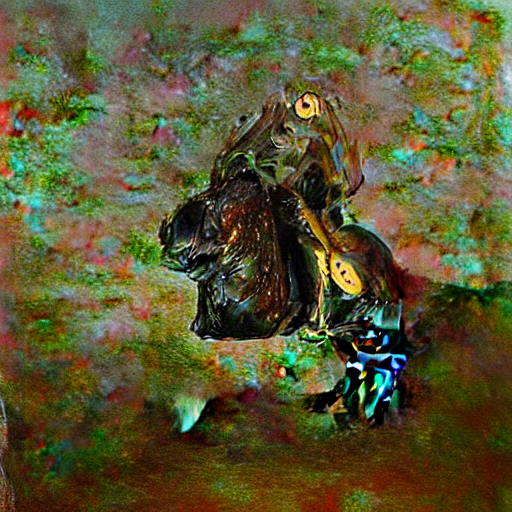

In [20]:
prompt = ["a photograph of an astronaut riding a horse"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

/tmp/ipykernel_59511/1657935708.py:18: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).to(torch_device) * scheduler.init_noise_sigma


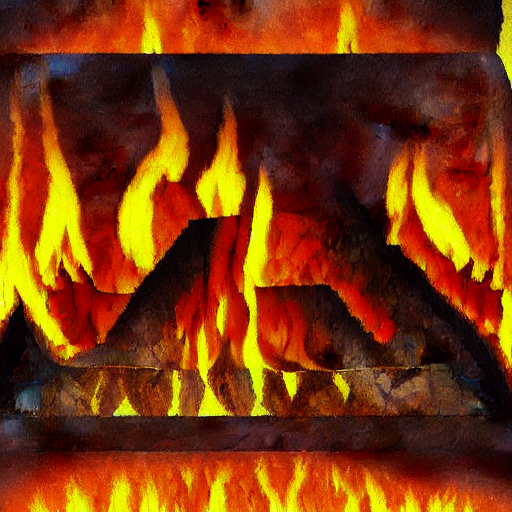

In [21]:
prompt = ["a campfire (oil on canvas)"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

# PART 2 (20 pts)

#### Additional Guidance
 How can we add some extra control to this generation process?

At each step, we're going to use our model as before to predict the noise component of x. Then we'll use this to produce a predicted output image, and apply some loss function to this image.

This function can be anything, but let's demo with a super simple example. If we want images that have a lot of blue, we can craft a loss function that gives a high loss if pixels have a low blue component:


In [22]:
import torch.nn.functional as F

def blue_loss(images):

    '''
        # TODO: this function should take in an images and return a scalar. (5 pts)
            - How far are the blue channel values to 0.9
    '''
    ###############################
    ###### YOUR CODE GOES HERE ####

    blue_channel = images[:, 2]
    blue_channel = (blue_channel - 0.9) ** 2
    loss = blue_channel.mean()

    ###############################
    return loss

/tmp/ipykernel_59511/4288363616.py:17: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).requires_grad_().to(torch_device) * scheduler.init_noise_sigma
50it [00:08,  5.86it/s]


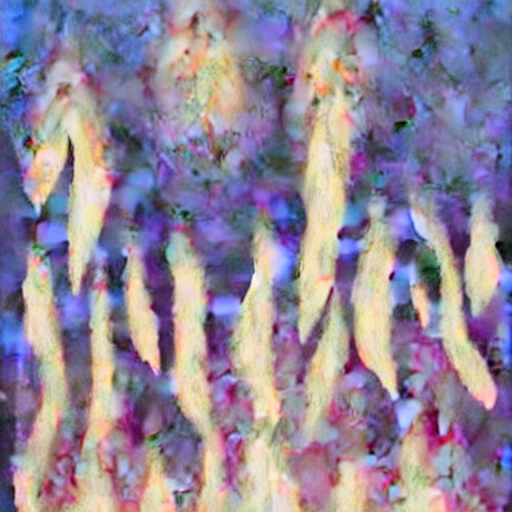

In [23]:

blue_loss_scale = 2500


def emb_to_latents_with_blue_loss(text_embeddings):
  '''
    # TODO (15 pts)
      - Use the model to predict the noise component of x.
      - Produce a predicted output image every 5 steps.
      - Compute the blue loss function and apply it to the latents.
  '''

  scheduler.set_timesteps(num_inference_steps)

  ###############################
  ###### YOUR CODE GOES HERE ####

  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).requires_grad_().to(torch_device) * scheduler.init_noise_sigma

  for i, t in tqdm(enumerate(scheduler.timesteps)):
      latent_input = scheduler.scale_model_input(torch.cat([latents] * 2), t)

      with torch.no_grad():
        noise_pred = unet(latent_input, t, encoder_hidden_states=text_embeddings).sample

      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)


      if i % 5 == 0:
        image = vae.decode(latents / 0.18215).sample
        loss = blue_loss((image / 2 + 0.5).clamp(0, 1))
        loss_gradient = torch.autograd.grad(loss, latents)[0]
        latents = latents - loss_gradient * blue_loss_scale

      latents = scheduler.step(noise_pred, t, latents).prev_sample

  return latents



  ###############################

prompt = ["a campfire (oil on canvas)"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents_with_blue_loss(text_embeddings)
latents_to_pil(latents)[0]

